# Assignment - Week 2

## Problem Statement

Implement the Variational Quantum Eigensolver (VQE) algorithm to determine the ground state and ground state energy of a simple Hamiltonian system using Qiskit.

1. Hamiltonian Definition:
   - Use the following Hamiltonian for a 2-qubit system:
    $H = X_0 X_1 + Y_0 Y_1 + Z_0 I_1$, here, $X, Y$ and $Z$ are Pauli operators, and $I$ is the identity operator.
2. Variational Ansatz:
   - Design a parameterized quantum circuit (ansatz) using rotational gates ($R_y, R_z$) and entangling gates (e.g., CNOT)
   - The ansatz should be general enough to approximate the ground state.
3. Cost Function:
   - Define the cost function as the expectation value of the Hamiltonian with respect to the trial state produced by the ansatz.
4. Optimization:
   - Use a classical optimizer (like gradient descent) to minimize the cost function and determine the parameters that approximate the ground state.
5. Execution:
   - Simulate the VQE circuit using Qiskit’s Aer simulator.
   - Compare the obtained ground state energy with the exact solution obtained via Qiskit’s NumPyMinimumEigensolver.
6. Results and Analysis:
   - Print the optimized ground state energy.
   - Compare it to the exact eigenvalue of the Hamiltonian.
   - Plot the convergence of the cost function over optimization iterations.

### Guidelines
- Refer to the Qiskit documentation for implementing VQE circuits and classical optimizers.
- Ensure that the code is modular, with clear comments explaining each step.


## Solution

## References
1. [IBM Quantum | Tutorials | Variational Quantum Eigensolver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)
2. [IBM Quantum | Guides | `AerSimulator`](https://docs.quantum.ibm.com/migration-guides/local-simulators#aersimulator)

In [1]:
import numpy as np

from scipy.linalg import eigh

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2
from qiskit_aer import AerSimulator

In [2]:
%matplotlib inline

In [20]:
# store data from previous runs of cost function
cost_history = {
    "iters": 0,     # iterations
    "prev_th": [],  # previous value of th
    "cost": []      # previous outputs of cost fn
}


def parameterized_ansatz(n_qubits = 2, n_layers = 1, linear = True):
    '''
    Return (parametrizable ansatz, number of parameters)
    '''

    qc = QuantumCircuit(n_qubits)
    th = []
    
    # number of params per qubit per layer
    # fixed coz Ry, Rz used
    n_params = 2
    
    # create param placeholders
    for i in range(n_layers):
        for j in range(n_qubits):
            th.append(Parameter(f"th_{i}_{j}_Ry"))
            th.append(Parameter(f"th_{i}_{j}_Rz"))

    # apply gates
    k = 0
    for _ in range(n_layers):
        for j in range(n_qubits):
            # convention: first angle is for Ry
            qc.ry(th[k], j)
            k += 1
            qc.rz(th[k], j)
            k += 1

        for j in range(n_qubits):
            # using linear entanglement ONLY for case of 2-qubits
            # because with change of basis, we can see that CX affects
            # both qubits equally, so expressibility won't be affected (probably)
            
            # if not linear, do circular entanglement
            if (j == n_qubits - 1) and not linear:
                qc.cx(j, 0)
            elif j < n_qubits - 1:
                qc.cx(j, j + 1)
    
    return qc, k


def initialize_parameters(n_params, vals = None) -> np.ndarray:
    '''
    Return `np.ndarray` of size `(n_params,)` based on `vals`:
    - `None` (default): randomly initialized
    - Numeric: all set to `vals` E [0, 2pi)
    '''
    if vals is None:
        return np.random.uniform(0, 2 * np.pi, size=(n_params,))
    else:
        # assuming vals E [0, 2pi)
        return np.ones(size=(n_params,)) * vals


def expectation(ansatz, observable, estimator, th):
    '''
    Return expectation of `observable` on `ansatz` with params `th` run using `estimator`
    '''
    pub = (ansatz, [observable], [th])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    
    return energy


def cost_fn(ansatz, observables, estimator, th, add_to_history=True):
    '''
    Return cost for `ansatz` with params `th` with `observables`, run using `estimator`
    '''
    # using C(th) = <O>, where O = Hamiltonian
    # only one observable
    cost = expectation(ansatz, observables[0], estimator, th)

    # modify cost history
    if add_to_history:
        cost_history["iters"] += 1
        cost_history["prev_th"] = th
        cost_history["cost"].append(cost)
    
    return cost


def calculate_gradients(bound_cost_fn, th, alpha):
    '''
    Return gradient using the parameter shift rule:
    
    `grad C = (C(th+) - C(th-)) / (2 * sin(alpha))`
    
    as `np.ndarray` of size `(n,1)`
    '''
    
    # apply using: th +- alpha*I
    # where th (n,1) is broadcast to size (n,n) of I
    delta = np.identity(th.size) * alpha
    return (bound_cost_fn(th + delta, False) - bound_cost_fn(th - delta, False)) / (2 * np.sin(alpha))


def update_parameters(th, gradients, learning_rate):
    '''
    Return `th` updated according to simple Gradient Descent
    
    `th' = th - grad * learning_rate`
    '''
    th_prime = th - gradients * learning_rate
    return th_prime
    

## Main training loop

In [21]:
# Step 0: Define backend and primitive
backend = AerSimulator()  # ref 2
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
estimator = EstimatorV2(mode=backend)

In [22]:
# Step 1: Define ansatz params, observables (hamiltonian) and optimizer params
n_qubits = 2
n_layers = 2

H = SparsePauliOp(["XX", "YY", "IZ"])
observables = [H]

learning_rate = 0.1
n_steps = 25

alpha = np.pi / 4

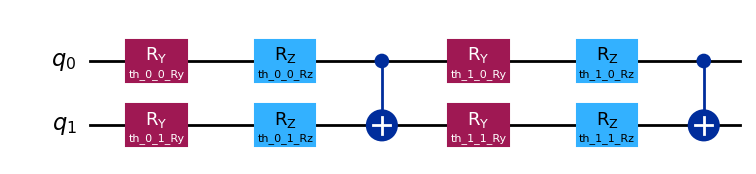

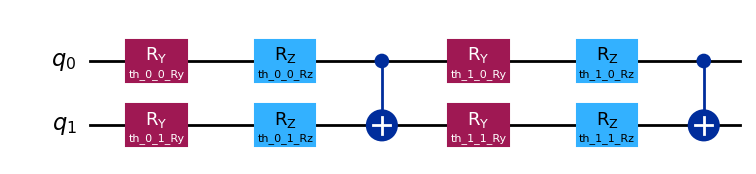

In [ ]:
# Step 2: Initialize circuit and parameters
ansatz, n = parameterized_ansatz(n_qubits=n_qubits, n_layers=n_layers, linear=True)
th = initialize_parameters(n)

# transpile circuit and transform observable to be backend-compatible
# ref 1
ansatz_isa = pm.run(ansatz)
observables_isa = [o.apply_layout(layout=ansatz_isa.layout) for o in observables]

# fixing the ansatz, observable and estimator for cost_fn, for use in optimizer
bound_cost_fn = lambda th, add_to_history=True: cost_fn(ansatz_isa, observables_isa, estimator, th, add_to_history)

# draw ansatz and isa ansatz
_ = ansatz.draw(output='mpl')
_ = ansatz_isa.draw(output='mpl', idle_wires=False)

In [ ]:
# NOTE: pretrained params, use for better results:
pretrained_params = np.array([4.1807811, 4.82180505, -1.5615796, 6.27185951, 5.94871168, 4.42402336, 4.71984558, 4.79599041])
# th = pretrained_params

In [51]:
# Training loop
for step in range(n_steps):    
    # 1. Evaluate the cost function
    cost = bound_cost_fn(th)
    print(f"[{cost_history['iters']}] C(θ) = {cost}")
    
    # 2. Calculate gradients with respect to parameters
    gradients = calculate_gradients(bound_cost_fn, th, alpha)
    
    # 3. Update parameters using gradient descent
    th = update_parameters(th, gradients, learning_rate)


# Step 4: Finalize results
trained_params = th
optimized_circuit = ansatz.assign_parameters(th)
ground_state_energy = expectation(ansatz_isa, H, estimator, th)


[51] C(θ) = -2.25439453125
[52] C(θ) = -2.26318359375
[53] C(θ) = -2.236328125
[54] C(θ) = -2.25927734375
[55] C(θ) = -2.20703125
[56] C(θ) = -2.216796875
[57] C(θ) = -2.2099609375
[58] C(θ) = -2.21337890625
[59] C(θ) = -2.19677734375
[60] C(θ) = -2.26220703125
[61] C(θ) = -2.2529296875
[62] C(θ) = -2.2255859375
[63] C(θ) = -2.22412109375
[64] C(θ) = -2.2548828125
[65] C(θ) = -2.22509765625
[66] C(θ) = -2.2294921875
[67] C(θ) = -2.2392578125
[68] C(θ) = -2.21728515625
[69] C(θ) = -2.2470703125
[70] C(θ) = -2.2666015625
[71] C(θ) = -2.251953125
[72] C(θ) = -2.2734375
[73] C(θ) = -2.2294921875
[74] C(θ) = -2.2197265625
[75] C(θ) = -2.22802734375


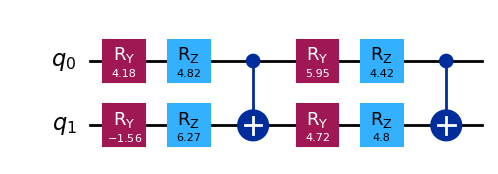

In [52]:
# draw final optimized circuit
_ = optimized_circuit.draw(output='mpl')

In [53]:
# `qiskit.algorithms.NumPyEigensolver` was deprecated in Qiskit 0.4 and is now removed based on online API docs
# using `scipy.linalg.eigh` for getting eigenvals

H_mat = H.to_matrix(sparse=False)
eigenvals, _ = eigh(H_mat)
ground_state_energy_theoretical = np.min(eigenvals)

In [54]:
print("(E_0)_calculated =", ground_state_energy)
print("(E_0)_theoretical =", ground_state_energy_theoretical)

(E_0)_calculated = -2.2490234375
(E_0)_theoretical = -2.236067977499788


In [55]:
trained_params

array([ 4.1807811 ,  4.82180505, -1.5615796 ,  6.27185951,  5.94871168,
        4.42402336,  4.71984558,  4.79599041])

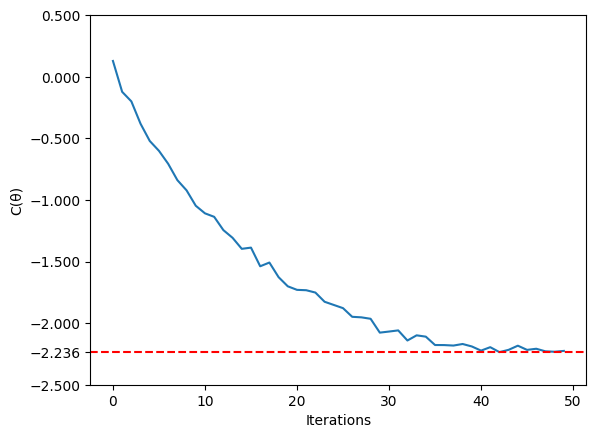

In [50]:
import matplotlib.pyplot as plt

# plot C(θ) vs Iterations
plt.plot(np.arange(cost_history["iters"]), cost_history["cost"])
plt.xlabel("Iterations")
plt.ylabel("C(θ)")

# plot theoretical ground state energy
plt.axhline(y=ground_state_energy_theoretical, color='r', ls='--')
plt.yticks(list(plt.yticks()[0]) + [ground_state_energy_theoretical])

plt.show()